## 正規化項
### Lasso

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [4]:
# 欠損値対応
df.dropna(inplace=True)

In [5]:
# データの準備
y_col = "Salary"
X = df.loc[:, df.columns!=y_col]
y = df[y_col]

# 標準化のために、値が数字のカラムのみを取得する
numeric_cols = X.select_dtypes(include=np.number).columns.to_list()

# ダミー変数を作成(カテゴリー変数を0, 1の数字に変換)
X = pd.get_dummies(X, drop_first=True)

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 標準化
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# テスト用の値も、学習用のデータでfitしたscalerを用いるので注意
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [6]:
# モデル学習
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

# 予測
y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mse)
print(mae)

lasso_model.coef_

117768.90478161341
250.24481877112976


array([-263.93470404,  267.52882597,   42.60344047,  -33.86419872,
          7.61638806,  125.23251733,  -29.82564501, -239.24447846,
        330.30504107,   -4.11414372,  259.64536978,    0.        ,
       -160.99905107,   71.08401856,   40.14808014,  -30.18012969,
          0.        ,  -93.87340542,   25.7211037 ])

### いくつかの係数が0になっているのが、Lassoの特徴！
※ Ridgeの場合は、それぞれが大まかには同じスピード0に近づいていくので、Lassoのような特徴量選択に効果がない

通常の線形回帰と比較してみる

In [7]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 予測
y_pred = lr_model.predict(X_test)


lr_model.coef_

array([-269.10981701,  272.90887884,   59.97669544,  -55.37512444,
          3.61504229,  131.08295524,  -14.78202567, -514.20110584,
        550.22369897,  -12.29554582,  299.04286135,    4.60615938,
       -156.78117836,   73.32237801,   54.94973217,  -35.64306984,
          1.59251626,  -95.02251105,   28.46798552])

### 次に、様々なλでLassoの精度を比較する
- $\lambda = 10^{-3} ~ 10^3 $
- 評価指標はMSE
- λを増加させたときのMSEの推移をplot
- λを増加させたときの特徴量の係数$\theta_j$の推移をplot

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.495e+06, tolerance: 3.232e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.067e+06, tolerance: 3.232e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.716e+06, toleranc

Text(0, 0.5, 'test MSE')

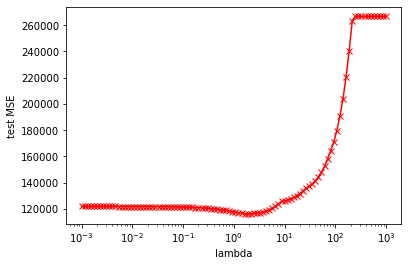

In [8]:
# lambda_list = np.linspace(0.001, 1000, 100)
# linespaceよりlogspaceの方が良い適切な幅を作成してくれる
lambda_list = np.logspace(-3, 3, 100)

mse_list = []
coefs = []
for lmd in lambda_list:
    # モデル学習
    lasso_model = Lasso(alpha=lmd)
    lasso_model.fit(X_train, y_train)

    # 予測
    y_pred = lasso_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    coefs.append(lasso_model.coef_)
    
plt.plot(lambda_list, mse_list, "x-r")
# スケールをlogにすると見やすい(片対数グラフにする)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("test MSE")

Text(0, 0.5, 'standardized coefficients')

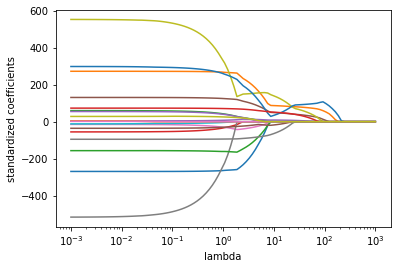

In [9]:
plt.plot(lambda_list, coefs)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("standardized coefficients")

In [11]:
# 最適な状態での係数を確認して、いらない特徴量を炙り出す
best_lambda = lambda_list[np.argmin(mse_list)]
lasso_model = Lasso(alpha=best_lambda)
lasso_model.fit(X_train, y_train)
pd.DataFrame({"coef": lasso_model.coef_, "column_name": X_train.columns.to_list()})

,coef,column_name
0,-258.654254,AtBat
1,262.703341,Hits
2,28.269934,HmRun
3,-15.642275,Runs
4,10.668062,RBI
5,119.976146,Walks
6,-42.540124,Years
7,-1.809967,CAtBat
8,135.784321,CHits
9,-0.000000,CHmRun


上の結果より、League_N, CHmRun, CRBIなどの特徴量は必要ないことがわかった！